In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go

In [37]:
import os
import sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [38]:
from core.time_series_clustering import KmeansClustering
from core.data_preparation import DataPreparation


In [39]:
from core.curve_fit import fit_polynomial_curve_to_data_and_visualize

Load and Prepare data to input to LSTM model

In [40]:
filepath = "../Data/JPM_Stock_Close.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-01-02,25.25,25.500000,24.799999,25.440001,14.986935,16739100
1,2003-01-03,25.50,25.990000,25.200001,25.940001,15.281493,12525700
2,2003-01-06,26.00,28.100000,25.959999,27.980000,16.483273,22932400
3,2003-01-07,27.98,28.290001,27.620001,27.840000,16.400805,17837500
4,2003-01-08,27.25,27.250000,26.510000,26.770000,15.770453,15857300


In [41]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='closing price'))


In [43]:
window_size = 20
prep = DataPreparation()
scaler = MinMaxScaler(feature_range=(-1, 1))

In [44]:
scaler, x_train, x_test, y_train_lstm, y_test_lstm = prep.normalize_and_prepare_data(data['Close'].values, scaler)

x_train.shape =  (3822, 20, 1)
y_train.shape =  (3822, 1)
x_test.shape =  (941, 20, 1)
y_test.shape =  (941, 1)


In [45]:
num_clusters = 5

In [46]:
kmeans = KmeansClustering(num_clusters)
kmeans.compute_clusters(x_train)

DBA k-means


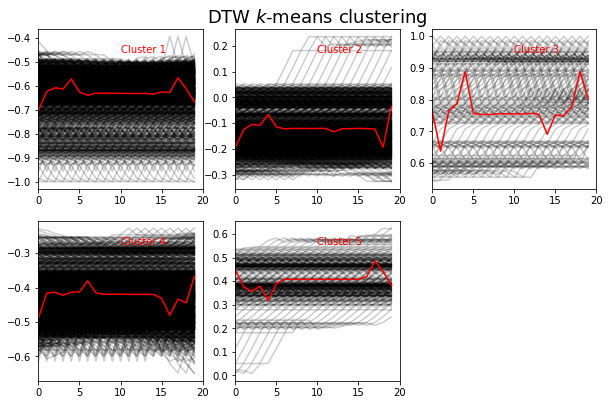

In [47]:
kmeans.visualize_clustering_results()

In [48]:
y_train = y_train_lstm.flatten().numpy()

In [49]:
type(y_train)

numpy.ndarray

In [50]:
train_errors = pd.read_csv('JPM_ErrorDistribution.csv', usecols=[2])
train_errors.head()

,diff
0,0.658983
1,0.250311
2,0.716368
3,0.711233
4,1.215355


In [51]:
clusters = []
for i in range(num_clusters):

    clusters.append(scaler.inverse_transform(kmeans.cluster_centers_[i].flatten().reshape(-1,1)))

In [52]:
kmeans.cluster_centers_[2].flatten()

array([0.76180098, 0.63808777, 0.76434718, 0.78742329, 0.88836871,
       0.75635861, 0.75367145, 0.75313332, 0.75540734, 0.75540734,
       0.75540734, 0.75486922, 0.75700436, 0.75396135, 0.69090472,
       0.75219684, 0.7490505 , 0.77859316, 0.88922377, 0.80188316])

In [53]:
train_preds = kmeans.predict(x_train)

In [54]:
model = torch.load('lstm_jpm.pt')
model.eval()

/home/ambekar/anaconda3/envs/rpy/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning:

source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.

/home/ambekar/anaconda3/envs/rpy/lib/python3.7/site-packages/torch/serialization.py:671: SourceChangeWarning:

source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.



LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [55]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

Test Score: 0.04 MAPE
R-squared value is 0.9149719332119162
RMSE:  6.908608702665318


#### Predict the cluster for forecast data

In [56]:
#prepare forecasts for clustering

preds = y_test_pred.detach().numpy()
preds = preds[:,0]
loop = len(preds) - window_size + 1 
forecasts = []

for i in range(loop):        
    window = preds[i:i+window_size]
    forecasts.append(window)  

forecasts = np.asarray(forecasts).reshape(-1, window_size, 1)

In [57]:
#prepare test gt for performance comparison

gt = y_test_lstm.detach().numpy()
gt = gt[:,0]
loop = len(gt) - window_size + 1 
test_gt = []

for i in range(loop):        
    window = gt[i:i+window_size]
    test_gt.append(window)  

test_gt = np.asarray(test_gt).reshape(-1, window_size, 1)

In [58]:
test_gt.shape, forecasts.shape

((922, 20, 1), (922, 20, 1))

In [59]:
# forecasts

In [60]:
res = kmeans.predict(forecasts)

#### Find distances between each cluster centroid and a reference time series

In [61]:
ref_ts = np.zeros(window_size)

In [62]:
ref_ts

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [63]:
clusters[0].flatten()

array([31.16439355, 35.23547673, 36.0051533 , 35.75994833, 37.91251041,
       35.13693901, 34.4147344 , 34.86634161, 34.85586078, 34.84240416,
       34.82317229, 34.82014952, 34.81318652, 34.81238281, 34.66785818,
       35.12471519, 35.02426667, 38.17433651, 35.82474358, 32.9798517 ])

In [64]:
clusters_wd_dist = []
for i in range(num_clusters):

    wd = kmeans.compute_wasserstein_distance(ref_ts, clusters[i].flatten())

    clusters_wd_dist.append(wd)


In [65]:
clusters_wd_dist

[35.04982995814085,
 61.072175705016235,
 106.67311631897877,
 45.550372003269075,
 88.01169659329406]

In [66]:
f380 = scaler.inverse_transform(forecasts[380].flatten().reshape(-1,1))

In [67]:
kmeans._get_statistical_dist_measures(f380.flatten(), np.zeros(20))

{'Anderson_Darling_dist': 3.708417172625208,
 'CVM_dist': 10.450000000000003,
 'DTS_dist': 40.74568639295174,
 'Kolmogorov_Smirnov_dist': 1.0000000000000002,
 'Kuiper_dist': 1.0000000000000002,
 'Wasserstein distance': 128.656979751587}

In [68]:
len(forecasts)

922

In [69]:
# np.random.seed(4)

## Fix these values of indices to reacreate/edit plots

indices = [421,  35, 252, 707, 284, 760, 515, 788, 638,  96, 869,  80,   4,
    531, 722]

# indices = np.random.choice(range(0, len(forecasts), 1), 15)
# indices

In [70]:
# t = [130, 184, 244, 225, 160, 235, 245, 176, 175, 30, 264, 256, 278, 300, 305, 380, 406, 420, 450, 467]

t = indices
df = kmeans.ecdf_between_cluster_and_data(t, scaler, forecasts, res, clusters_wd_dist)

In [71]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance
0,421,1.299357,2,106.673116,6.798281,19.0,8.993197,1.00,1.00,27.479428
1,35,0.768822,2,106.673116,1.701500,4.4,0.647668,0.30,0.50,1.087778
2,252,0.862536,2,106.673116,5.690237,15.8,1.941159,0.85,0.85,5.003207
3,707,1.489479,2,106.673116,6.798281,19.0,12.110737,1.00,1.00,37.265970
4,284,0.873205,2,106.673116,6.072487,16.8,2.092417,0.90,0.90,5.571185
5,760,1.589170,2,106.673116,6.798281,19.0,13.718685,1.00,1.00,42.396409
6,515,0.635717,2,106.673116,4.772831,13.1,2.789769,0.75,0.75,6.640026
7,788,1.513594,2,106.673116,6.798281,19.0,12.455031,1.00,1.00,38.507655
8,638,0.986508,2,106.673116,6.734996,18.8,4.000323,0.95,0.95,11.396751
9,96,0.919042,2,106.673116,6.544499,18.2,2.834686,0.90,0.90,7.925381


In [72]:
# df['WD ratio'] = (df['Wasserstein_dist']) / 1430.619949

In [73]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance
0,421,1.299357,2,106.673116,6.798281,19.0,8.993197,1.00,1.00,27.479428
1,35,0.768822,2,106.673116,1.701500,4.4,0.647668,0.30,0.50,1.087778
2,252,0.862536,2,106.673116,5.690237,15.8,1.941159,0.85,0.85,5.003207
3,707,1.489479,2,106.673116,6.798281,19.0,12.110737,1.00,1.00,37.265970
4,284,0.873205,2,106.673116,6.072487,16.8,2.092417,0.90,0.90,5.571185
5,760,1.589170,2,106.673116,6.798281,19.0,13.718685,1.00,1.00,42.396409
6,515,0.635717,2,106.673116,4.772831,13.1,2.789769,0.75,0.75,6.640026
7,788,1.513594,2,106.673116,6.798281,19.0,12.455031,1.00,1.00,38.507655
8,638,0.986508,2,106.673116,6.734996,18.8,4.000323,0.95,0.95,11.396751
9,96,0.919042,2,106.673116,6.544499,18.2,2.834686,0.90,0.90,7.925381


In [74]:
df['WD ratio'] = df['Wasserstein distance'] / df['WD origin']

In [75]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio
0,421,1.299357,2,106.673116,6.798281,19.0,8.993197,1.00,1.00,27.479428,0.257604
1,35,0.768822,2,106.673116,1.701500,4.4,0.647668,0.30,0.50,1.087778,0.010197
2,252,0.862536,2,106.673116,5.690237,15.8,1.941159,0.85,0.85,5.003207,0.046902
3,707,1.489479,2,106.673116,6.798281,19.0,12.110737,1.00,1.00,37.265970,0.349347
4,284,0.873205,2,106.673116,6.072487,16.8,2.092417,0.90,0.90,5.571185,0.052227
5,760,1.589170,2,106.673116,6.798281,19.0,13.718685,1.00,1.00,42.396409,0.397442
6,515,0.635717,2,106.673116,4.772831,13.1,2.789769,0.75,0.75,6.640026,0.062246
7,788,1.513594,2,106.673116,6.798281,19.0,12.455031,1.00,1.00,38.507655,0.360987
8,638,0.986508,2,106.673116,6.734996,18.8,4.000323,0.95,0.95,11.396751,0.106838
9,96,0.919042,2,106.673116,6.544499,18.2,2.834686,0.90,0.90,7.925381,0.074296


In [76]:
rmse_errors = []
mape_errors = []
r2score = []
for i in t:

    forecast = scaler.inverse_transform(forecasts[i])
    gt = scaler.inverse_transform(test_gt[i])
    rmse = math.sqrt(mean_squared_error(gt, forecast))
    rmse_errors.append(rmse)

    mape = mean_absolute_percentage_error(gt, forecast)
    mape_errors.append(mape*100)

    r2 = r2_score(gt, forecast)
    r2score.append(r2)

In [77]:
df = df.assign(**{'RMSE': rmse_errors, 'MAPE':mape_errors, 'R2-score': r2score})

In [78]:
df 

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio,RMSE,MAPE,R2-score
0,421,1.299357,2,106.673116,6.798281,19.0,8.993197,1.00,1.00,27.479428,0.257604,2.394076,0.015383,-0.573088
1,35,0.768822,2,106.673116,1.701500,4.4,0.647668,0.30,0.50,1.087778,0.010197,2.271938,0.018019,0.544335
2,252,0.862536,2,106.673116,5.690237,15.8,1.941159,0.85,0.85,5.003207,0.046902,2.429642,0.019611,-0.633177
3,707,1.489479,2,106.673116,6.798281,19.0,12.110737,1.00,1.00,37.265970,0.349347,8.991106,0.056735,-11.116920
4,284,0.873205,2,106.673116,6.072487,16.8,2.092417,0.90,0.90,5.571185,0.052227,1.647422,0.011298,0.469524
5,760,1.589170,2,106.673116,6.798281,19.0,13.718685,1.00,1.00,42.396409,0.397442,14.624966,0.088592,-57.751845
6,515,0.635717,2,106.673116,4.772831,13.1,2.789769,0.75,0.75,6.640026,0.062246,6.147967,0.050778,-0.199892
7,788,1.513594,2,106.673116,6.798281,19.0,12.455031,1.00,1.00,38.507655,0.360987,8.946086,0.055165,-10.985354
8,638,0.986508,2,106.673116,6.734996,18.8,4.000323,0.95,0.95,11.396751,0.106838,2.825932,0.018106,-0.162424
9,96,0.919042,2,106.673116,6.544499,18.2,2.834686,0.90,0.90,7.925381,0.074296,3.050322,0.019945,0.208819


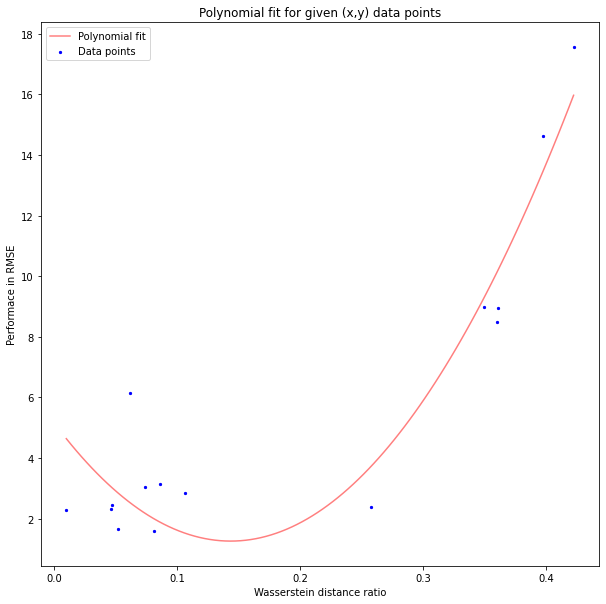

In [79]:
fit_polynomial_curve_to_data_and_visualize(df['WD ratio'].values, rmse_errors, 2, xlabel='Wasserstein distance ratio', ylabel='Performace in RMSE')

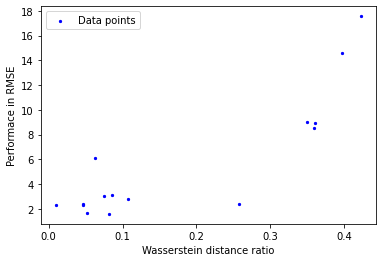

In [80]:
#Plotting
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.scatter(df['WD ratio'], rmse_errors, s = 5, color = 'b', label = 'Data points')
ax1.set_xlabel('Wasserstein distance ratio')
ax1.set_ylabel('Performace in RMSE')
ax1.legend()
plt.show()

#### Find MSE of each data point using CONFINE method

In [81]:
for i in range(num_clusters):
    print(f"cluster {i}- {len(kmeans.data[kmeans.data_preds == i])}")

cluster 0- 1406
cluster 1- 812
cluster 2- 112
cluster 3- 1266
cluster 4- 226


In [82]:
num_neighbors = 112

In [83]:
y_train = y_train_lstm.flatten().numpy()

##### Get indices of the training points that have been assigned to respective cluster

In [84]:
cluster0 = (np.where(kmeans.labels_ == 0))
cluster1 = (np.where(kmeans.labels_ == 1))
cluster2 = (np.where(kmeans.labels_ == 2))
cluster3 = (np.where(kmeans.labels_ == 3))
cluster4 = (np.where(kmeans.labels_ == 4))

##### Get the difference between train preds and train gt values 

In [85]:
train_diff_df = pd.read_csv('JPM_ErrorDistribution.csv', usecols=[2])
train_diff_df.head()

,diff
0,0.658983
1,0.250311
2,0.716368
3,0.711233
4,1.215355


##### Get training points (members) of each cluster 

In [86]:
training_diff = train_diff_df['diff']
training_diff = training_diff.values

In [87]:
type(training_diff)

numpy.ndarray

In [88]:
cluster0_errors = training_diff[cluster0[0]]
cluster1_errors = training_diff[cluster1[0]]
cluster2_errors = training_diff[cluster2[0]]
cluster3_errors = training_diff[cluster3[0]]
cluster4_errors = training_diff[cluster4[0]]

In [89]:
np.random.seed(21)
cluster2_neighbors = np.random.choice(cluster2_errors, num_neighbors, replace=False)
cluster3_neighbors = np.random.choice(cluster3_errors, num_neighbors, replace=False)

In [90]:
squared_error_2 = [n ** 2 for n in cluster2_neighbors]
squared_error_2 = np.array(squared_error_2)

In [91]:
squared_error_3 = [n ** 2 for n in cluster3_neighbors]
squared_error_3 = np.array(squared_error_3)

In [92]:
scaler = MinMaxScaler(feature_range=(0, 1))
se_norm_2 = scaler.fit_transform(squared_error_2.reshape(-1, 1))

In [93]:
scaler = MinMaxScaler(feature_range=(0, 1))
se_norm_3 = scaler.fit_transform(squared_error_3.reshape(-1, 1))

In [94]:
se_norm_2 = np.around(se_norm_2, 4)

In [95]:
se_norm_3 = np.around(se_norm_3, 4)

In [96]:
mse_2 = np.mean(se_norm_2)

In [97]:
mse_2 = np.round(mse_2, 4)
mse_2

0.0778

In [98]:
mse_3 = np.mean(se_norm_3)

In [99]:
mse_3 = np.round(mse_3, 4)
mse_3

0.053

In [100]:
confine_mse = []

In [101]:
for i in df['Assigned cluster']:

    if i==2:
        confine_mse.append(mse_2) 
    elif i==3:
        confine_mse.append(mse_3)    


# confine_mse = [0.3188, 0.2606, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.2606, 0.3188, 0.3188, 0.3188, 0.3188,
#                 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188]

In [102]:
len(confine_mse)

15

In [103]:
df['mse'] = confine_mse

In [104]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio,RMSE,MAPE,R2-score,mse
0,421,1.299357,2,106.673116,6.798281,19.0,8.993197,1.00,1.00,27.479428,0.257604,2.394076,0.015383,-0.573088,0.0778
1,35,0.768822,2,106.673116,1.701500,4.4,0.647668,0.30,0.50,1.087778,0.010197,2.271938,0.018019,0.544335,0.0778
2,252,0.862536,2,106.673116,5.690237,15.8,1.941159,0.85,0.85,5.003207,0.046902,2.429642,0.019611,-0.633177,0.0778
3,707,1.489479,2,106.673116,6.798281,19.0,12.110737,1.00,1.00,37.265970,0.349347,8.991106,0.056735,-11.116920,0.0778
4,284,0.873205,2,106.673116,6.072487,16.8,2.092417,0.90,0.90,5.571185,0.052227,1.647422,0.011298,0.469524,0.0778
5,760,1.589170,2,106.673116,6.798281,19.0,13.718685,1.00,1.00,42.396409,0.397442,14.624966,0.088592,-57.751845,0.0778
6,515,0.635717,2,106.673116,4.772831,13.1,2.789769,0.75,0.75,6.640026,0.062246,6.147967,0.050778,-0.199892,0.0778
7,788,1.513594,2,106.673116,6.798281,19.0,12.455031,1.00,1.00,38.507655,0.360987,8.946086,0.055165,-10.985354,0.0778
8,638,0.986508,2,106.673116,6.734996,18.8,4.000323,0.95,0.95,11.396751,0.106838,2.825932,0.018106,-0.162424,0.0778
9,96,0.919042,2,106.673116,6.544499,18.2,2.834686,0.90,0.90,7.925381,0.074296,3.050322,0.019945,0.208819,0.0778


In [105]:
df['staDRE'] = (2 - df['mse'] - df['WD ratio'] ) / 2

In [106]:
df_RE = df[['Test point', 'Assigned cluster', 'RMSE', 'MAPE', 'R2-score', 'WD origin', 'Wasserstein distance', 'WD ratio', 'mse', 'staDRE']]

In [107]:
df_RE

,Test point,Assigned cluster,RMSE,MAPE,R2-score,WD origin,Wasserstein distance,WD ratio,mse,staDRE
0,421,2,2.394076,0.015383,-0.573088,106.673116,27.479428,0.257604,0.0778,0.832298
1,35,2,2.271938,0.018019,0.544335,106.673116,1.087778,0.010197,0.0778,0.956001
2,252,2,2.429642,0.019611,-0.633177,106.673116,5.003207,0.046902,0.0778,0.937649
3,707,2,8.991106,0.056735,-11.116920,106.673116,37.265970,0.349347,0.0778,0.786426
4,284,2,1.647422,0.011298,0.469524,106.673116,5.571185,0.052227,0.0778,0.934987
5,760,2,14.624966,0.088592,-57.751845,106.673116,42.396409,0.397442,0.0778,0.762379
6,515,2,6.147967,0.050778,-0.199892,106.673116,6.640026,0.062246,0.0778,0.929977
7,788,2,8.946086,0.055165,-10.985354,106.673116,38.507655,0.360987,0.0778,0.780606
8,638,2,2.825932,0.018106,-0.162424,106.673116,11.396751,0.106838,0.0778,0.907681
9,96,2,3.050322,0.019945,0.208819,106.673116,7.925381,0.074296,0.0778,0.923952


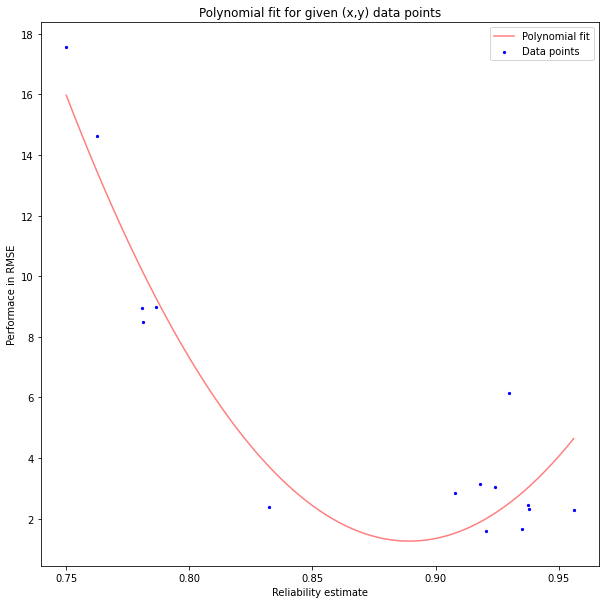

In [108]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['RMSE'].values, 2, xlabel='Reliability estimate', ylabel='Performace in RMSE')

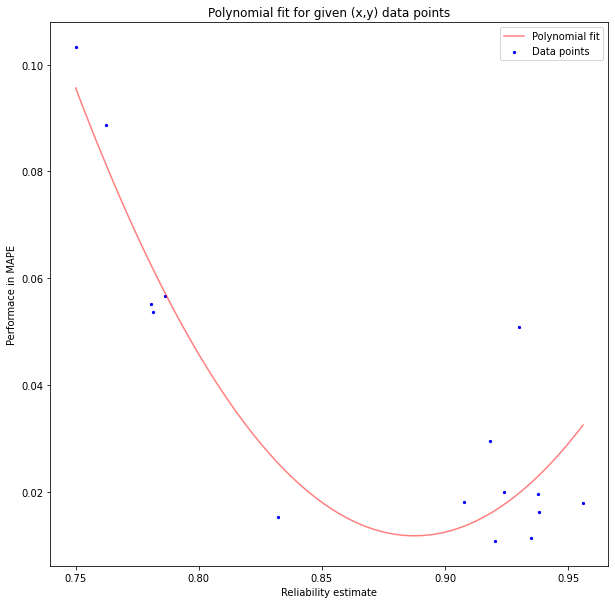

In [109]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['MAPE'].values, 2, xlabel='Reliability estimate', ylabel='Performace in MAPE')

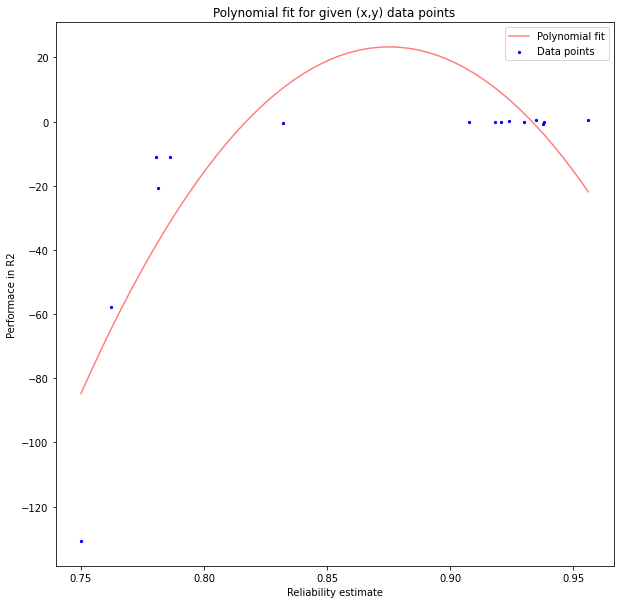

In [110]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['R2-score'].values, 2, xlabel='Reliability estimate', ylabel='Performace in R2')

In [111]:
df_RE.to_csv('JPM_stadre_new.csv', index=False)

In [112]:
scaler = MinMaxScaler()

In [113]:
x = np.array(df_RE['staDRE'].values)
y = np.array(df_RE['RMSE'].values)
# ya = np.array(airtel['MAPE'].values)
# ya = np.array(airtel['R2-score'].values)

z = np.polyfit(x, y, 2)

fit = np.poly1d(z)

x_min = x.min()
x_max = x.max()

xp = np.linspace(x_min, x_max, 100)
yp = fit(xp)

In [114]:
fit

poly1d([  759.38500962, -1350.6036308 ,   601.78359321])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


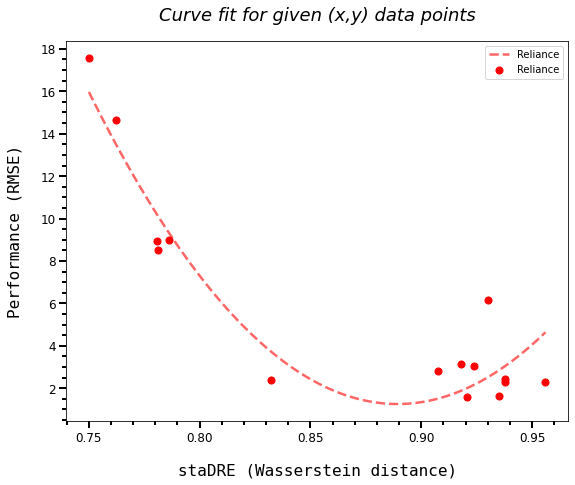

In [115]:
#Plotting RMSE-staDRE
fig1 = plt.figure(figsize=(9,7))
ax1 = fig1.subplots()
ax1.plot(xp, yp, 'r', linestyle='dashed', linewidth=2.5, alpha = 0.6, label = 'Reliance')
ax1.scatter(x, y, 50, 'r', "o", label = 'Reliance')
ax1.set_xlabel('staDRE (Wasserstein distance)', fontsize=16, family='monospace')
plt.xticks(fontsize=12)
ax1.tick_params(which='both', width=2, length=7)
ax1.tick_params(which='minor', length=4)
ax1.xaxis.labelpad = 18
ax1.set_ylabel('Performance (RMSE)', fontsize=16, family='monospace')
plt.yticks(fontsize=12)
ax1.yaxis.labelpad = 18
ax1.set_title('Curve fit for given (x,y) data points', fontsize=18, style='italic', pad=20)
plt.minorticks_on()
ax1.legend(loc='best')

plt.savefig('RMSE_vs._staDRE.eps', dpi=500)
plt.savefig('RMSE_vs._staDRE.jpg', dpi=500)
plt.savefig('RMSE_vs._staDRE.svg', dpi=500)
plt.show()

